In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기

In [2]:
data = pd.read_csv('./TrafficData/4-Copy1.csv')
data = data['volumn']
sequence_length = 1440
pred_len = 1

In [3]:
from torch import FloatTensor as FloatTensor

In [4]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [5]:
split = 10080
x_train,y_train = seq_data(data.iloc[:-split],sequence_length,pred_len)

/tmp/ipykernel_2436255/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [6]:
batch_size = 64
train_dataset = TensorDataset(x_train,y_train)
training = DataLoader(train_dataset,batch_size= batch_size)

In [7]:
seed = 42

In [8]:
device = torch.device("cuda:0")

In [9]:
X_test = torch.FloatTensor(data.iloc[-split-sequence_length:-split].values).to(device)
# X_train의 마지막 인덱스에서 sequece_length만큼 뒤에 부분을 잘라오기
X_test = X_test.view(1,1,sequence_length)

In [10]:
target = data.iloc[-split]
target = FloatTensor([target]).view(-1,1)
target

tensor([[90520.]])

In [11]:
# class Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.seq_len = 1440
#         self.pred_len = 1
#         self.first_layer = nn.Linear(self.seq_len,self.pred_len)
#         self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
#         self.weight_df = pd.DataFrame({"weight":self.first_layer.weight.cpu().detach().numpy().reshape(-1)})
#         # weight update를 위한 데이터프레임 이를 사용해야지 인덱스가 바뀌는 문제를 고정된 인덱스로 해결 가능
#     def forward(self,x):
#         return self.first_layer(x) 
# #     def reset_forward(self,x,train_idx,prev_idx): # idx는 attribution이 높은 것들의 index 리스트
# #         if train_idx == None: 
# #             return self.forward(x) # forward를 호출 클래스 내의 호출은 무조건 self를 붙여야 된다.
# #         weight_tensor = self.first_layer.weight
# # #         print(len(prev_idx),weight_tensor.size())
# #         self.weight_df.iloc[prev_idx] = weight_tensor.cpu().detach().numpy().reshape(-1,1)
# #         weight_arr = self.weight_df.iloc[train_idx].values.reshape(-1) # index에 해당하는 array만 뽑는다.
# #         weight_tensor = torch.FloatTensor(weight_arr).view(self.pred_len,-1) # 해당하는 인덱스만 뽑은후 텐서화
        
# #         self.first_layer = nn.Linear(len(train_idx),self.pred_len)
# #         self.first_layer.weight = nn.Parameter(weight_tensor)
# #         self.first_layer.weight.requires_grad = True
# #         self.first_layer.to(device)
# #         return self.first_layer(x[:,:,train_idx]) # 새로 설정한 layer에 input을 집어넣음

In [12]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

weight를 뽑으면 순서대로 정렬 돼있을거임 

In [13]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
train_index = np.arange(1440)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
criterion = SMAPE()

In [14]:
n = len(training)

In [15]:
X_test.size()

torch.Size([1, 1, 1440])

### Full-Trained Model(M) 구성

In [16]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

Epoch [1]/[100] running accumulative loss across all batches: 42.193
Epoch [21]/[100] running accumulative loss across all batches: 41.823
Epoch [41]/[100] running accumulative loss across all batches: 42.617
Epoch [61]/[100] running accumulative loss across all batches: 29.944
Epoch [81]/[100] running accumulative loss across all batches: 38.356


In [17]:
pred = model(X_test)
pred= pred.cpu().detach().view(-1,1)
result = criterion(pred,target).item()*100
result

16.206350922584534

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
train_index = list(range(1440))
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_test = nt_ig.attribute(X_test[:,:,train_index])
attr_df = pd.DataFrame({"attr":nt_ig_attr_test.cpu().numpy().reshape(-1)})
attr_df

,attr
0,78.814694
1,-5.722514
2,133.683525
3,91.072364
4,165.484674
...,...
1435,1860.919755
1436,1924.544805
1437,2007.469950
1438,1993.231181


## Scaling

In [20]:
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,0.074121
1,-0.172791
2,0.234380
3,0.109923
4,0.327263
...,...
1435,5.279213
1436,5.465046
1437,5.707250
1438,5.665662


In [21]:
attr_df.describe()

,attr
count,1.440000e+03
mean,3.454027e-17
std,1.000347e+00
min,-7.387347e+00
25%,-3.980206e-01
50%,-7.418226e-02
75%,2.955323e-01
max,6.126783e+00


mean = 0이고 표준편차가 1인 분포로 변환

## HyperParameter를 0.01로 둔 이후에 (+)(-) H.P 범위 안에 들어있는 attribution을 삭제

In [22]:
hyper_parameter = 0.07 # 
train_index = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
len(train_index)

1258

In [23]:
inputs

tensor([[[ 97152.,  93410.,  97749.,  ..., 103395.,  99170., 103273.]],

        [[ 93410.,  97749.,  92393.,  ...,  99170., 103273.,  97323.]],

        [[ 97749.,  92393.,  94468.,  ..., 103273.,  97323., 102155.]],

        ...,

        [[ 85870.,  82298.,  85843.,  ...,  91668.,  87325.,  91681.]],

        [[ 82298.,  85843.,  85797.,  ...,  87325.,  91681.,  88167.]],

        [[ 85843.,  85797.,  90281.,  ...,  91681.,  88167.,  89379.]]],
       device='cuda:0')

## 해당하는 인덱스만을 사용하여서 모델 Fully-Training

In [24]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

In [25]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
criterion = SMAPE()

In [26]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
train_index = train_index
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        
        outputs = model(inputs)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

Epoch [1]/[100] running accumulative loss across all batches: 42.868
Epoch [21]/[100] running accumulative loss across all batches: 42.129
Epoch [41]/[100] running accumulative loss across all batches: 34.844
Epoch [61]/[100] running accumulative loss across all batches: 31.493
Epoch [81]/[100] running accumulative loss across all batches: 40.553


In [27]:
model

Model(
  (first_layer): Linear(in_features=1258, out_features=1, bias=True)
)

In [28]:
pred = model(X_test)
pred= pred.cpu().detach().view(-1,1)
nine_result = criterion(pred,target).item()*100
nine_result

0.732589652761817

### 1. 0.01 비율로 제거했을때: 22.309105098247528<br>
**-> 아마도 쓸데없는 것들이 더  attribution을 얻었기 때문에 그럴 확률이 높다고 생각됨**<br>
### 2. 0.07 비율로 제거했을때: 0.732589652761817   ????????????????????<br>
**-> incomparable하게 좋은결과?**

## Hyper-Parameter를 Grid-Search를 통해서 loss 탐색하기
**수정(1)&rightarrow; K-Fold 교차검증은 적합하지 않은것 같기 때문에, 직접 훈련을 구성하여서 진행해보겠다**

In [29]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import KFold

#### GridSearch가 찾을 hyperparameter 찾기

In [30]:
index_list = []

for hyper_parameter in np.arange(0.01,1.01,0.01):
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

100

In [31]:
# param_grid = {   
#     'eraser' : index_list
# }
# estimator = Model()
# kf = KFold(random_state=seed,n_)

In [32]:
### 원래 난수가 선언된 위치
cnt = 0
out_list = []
num_epochs = 100
criterion = SMAPE()
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    
    train_idx = idx
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs

            outputs = model(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
    cnt+=1
    # 모델 Fully-Training 완료
    pred = model(X_test)
    pred= pred.cpu().detach().view(-1,1)
    result = criterion(pred,target).item()*100
    out_list.append(result)    

0번째 모델 Training 완료 마지막 Epoch loss:45.270270076101625
1번째 모델 Training 완료 마지막 Epoch loss:45.49980658263177
2번째 모델 Training 완료 마지막 Epoch loss:38.23693875815267
3번째 모델 Training 완료 마지막 Epoch loss:33.38233335106851
4번째 모델 Training 완료 마지막 Epoch loss:31.77856541212613
5번째 모델 Training 완료 마지막 Epoch loss:35.1335709923269
6번째 모델 Training 완료 마지막 Epoch loss:34.97895356202411
7번째 모델 Training 완료 마지막 Epoch loss:41.88427872842648
8번째 모델 Training 완료 마지막 Epoch loss:37.29739608417187
9번째 모델 Training 완료 마지막 Epoch loss:38.93856781352068
10번째 모델 Training 완료 마지막 Epoch loss:27.572387404452627
11번째 모델 Training 완료 마지막 Epoch loss:39.37022348421965
12번째 모델 Training 완료 마지막 Epoch loss:37.374728203481325
13번째 모델 Training 완료 마지막 Epoch loss:27.714299117367297
14번째 모델 Training 완료 마지막 Epoch loss:31.06614783119027
15번째 모델 Training 완료 마지막 Epoch loss:33.373337184192145
16번째 모델 Training 완료 마지막 Epoch loss:35.44297510253213
17번째 모델 Training 완료 마지막 Epoch loss:25.635830189153623
18번째 모델 Training 완료 마지막 Epoch loss:32.6584284128534

<AxesSubplot: >

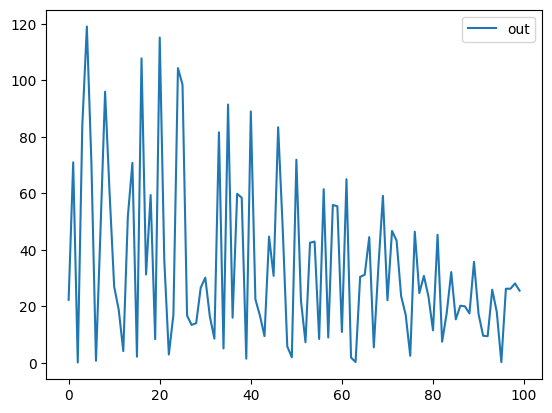

In [33]:
out_df = pd.DataFrame({"out":out_list})
out_df.plot()

### 최소값 찾기

In [34]:
out_df.iloc[6]

out    0.73259
Name: 6, dtype: float64

### result 1 &rightarrow; out의 추이를 보면 일정한 loss처럼 일정하게 감소되는 것이 아닌 불규칙한 것을 확인할 수 있다.
### result 2 &rightarrow; 위의 결과를 보면 난수에 따라서 결과값의 차이가 매우크다. 모델이 단순하기 때문에 그런건가?
&rightarrow;&rightarrow; 모델 예측결과를 만들어낼때 수정전에는 cnt위에 선언됐었다
### result 3 &rightarrow; 눈에 띄는 성능적 향상이 있음은 비교적 확실한 것으로 보인다.

<font color = blue>**X_test는 실제로는 train_set중에 일부이다. 그렇다면 train-validation set으로 쪼개서 validation set으로 나눠서 성능측정을 해보자**</font>